# Praktikum 2, Monte Carlo
## Math modeling of the atmosphere


## Computing average autoconversion

Autoconversion is the process by which small cloud droplets grow in size and become rain drops. It can be approximated as a function of two variables, $\chi$ and $N_c$:

$$A(\chi, N_c)=H(\chi){\chi}^{\alpha}{N_c}^{\beta}$$

In [116]:
import numpy as np
from scipy.special import gamma, pbdv
from matplotlib import pyplot as plt

In [117]:
def a_chi_n_c(chi, n_c, alpha, beta):
    return np.heaviside(chi, 1) * np.power(chi, alpha) * np.power(n_c, beta)

Here $\chi$ is related to clound water mixing ratio, and $N_c$ is the number of cloud droplets. The expontent $\alpha$ is often taken to equal 2.47, and the exponent $\beta$ is often taken to equal -1.79. Therefore, if there is more cloud water or larger drops, rain forms more easily.

In [118]:
alpha = 2.47
beta = -1.79

If we integrate over this autoconversion expression over a bivariate PDF that is normal in $\chi$ and lognormal in $N_c$, we find

TODO!

1. Write a python function that computes the exact average autoconversion rate given by the formula above. As input, it should take in the means, standard deviations, and correlation of the PDF, along with the exponents $\alpha$ and $\beta$. As output, it should produce $\overline{A(\chi,N_c)}$. Use the `scipy.special` function, `pbdv`.

In [119]:
def exact_average_autoconversion_rate(my_n_c, my_chi,
                                      sigma_chi, sigma_n_c,
                                      r_chi_n_c, alpha, beta):
    return (1 / (np.sqrt(2 * np.pi))) * (sigma_chi ** alpha) * np.exp(
        (my_n_c * beta) + ((1 / 2) * sigma_n_c ** 2 * beta ** 2) - (
                (1 / 4) * ((my_chi / sigma_chi) + r_chi_n_c * sigma_n_c * beta) ** 2)) * gamma(alpha + 1) * \
        pbdv(-(alpha + 1), -((my_chi / sigma_chi) + r_chi_n_c * sigma_n_c * beta))[0]

2. To represent the $\chi$ distribution, create a sample from a univariate uniform distribution and transform it to a standard normal. To represent the $N_c$ distribution, create another, independent sample from a univariate standard normal. Together, these points form a sample from a bivariate,
uncorrelated standard normal distribution.

In [120]:
def draw_from_uniform_dist(n: int):
    from numpy import random
    return random.uniform(size=n)

In [121]:
def transform_to_standard_normal(points):
    from scipy.stats import norm
    return norm.ppf(points)

In [122]:
exact = exact_average_autoconversion_rate(0, 0, 1, 1, 0, alpha, beta)

In [123]:
num_points = 1000


def create_chi_n_c(num_points: int):
    chi = np.array(transform_to_standard_normal(draw_from_uniform_dist(num_points)))
    n_c = np.array(transform_to_standard_normal(draw_from_uniform_dist(num_points)))
    return np.array([chi, n_c])

3. Use a Cholesky decomposition in order to transform the distribution from a 2D uncorrelated standard normal to a 2D correlated normal. Assume a correlation $r_{(\chi,N_c)n}$, a mean $N_c$ of $\mu_{N_{cn}}$ , etc.

$$
\Sigma = \begin{bmatrix}
        1 & r_{12} \\
        r_{12} & 1
        \end{bmatrix}
$$
$$
L = \begin{bmatrix}
    \sigma_x & 0 \\
    \sigma_y * r_{12} & \sigma_y\sqrt{1-{r_{12}}^2}
    \end{bmatrix}
$$

And the decomposition formular:
$$ X = L \cdot Y + \mu $$

In [124]:
def transform_to_correlated_by_cholesky(sigma_x, sigma_y, r_12, Y, my):
    import numpy as np
    L = np.array([[sigma_x, 0], [sigma_y * r_12, sigma_y * np.sqrt(1 - (r_12 ** 2))]])
    return L.dot(Y) + my

4. In order to transform to a lognormal distribution in $N_c$, take the exponential of the $N_c$ component of the sample points.

In [125]:
def lognormal_correlated_bivariate_dist(correlated_bivariate_dist):
    return np.array([correlated_bivariate_dist[0].copy(), np.exp(correlated_bivariate_dist[1])])

5. Use Monte Carlo integration in order to find the integral $\overline{A(\chi,N_c)}$.

In [126]:
def A_chi_N_c_Monte_Carlo(lognormal_correlated_bivariate_dist, alpha=alpha, beta=beta):
    return np.average(
        [np.nan_to_num(a_chi_n_c(chi=c, n_c=nc, alpha=alpha, beta=beta)) for c in lognormal_correlated_bivariate_dist[0]
         for nc in
         lognormal_correlated_bivariate_dist[1]])


print(A_chi_N_c_Monte_Carlo(lognormal_correlated_bivariate_dist(
    transform_to_correlated_by_cholesky(sigma_x=1, sigma_y=1, r_12=0.999, Y=create_chi_n_c(num_points), my=0)), alpha,
    beta))
print(exact)

C:\Users\sberg\AppData\Local\Temp\ipykernel_16532\77067271.py:2: RuntimeWarning: invalid value encountered in power
  return np.heaviside(chi, 1) * np.power(chi, alpha) * np.power(n_c, beta)


2.5264930284349973
3.0178592303669873


6. Compute the Monte Carlo estimate for multiple values of N. Check whether your answer converges to the analytic answer as $\frac{1}{\sqrt{n}}$. Make sure that it converges for non-zero values of $r_{(\chi,N_c)n}$. To improve the convergence rate, choose a value of $\sigma_{N_{cn}} < 2$.

C:\Users\sberg\anaconda3\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\sberg\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\sberg\AppData\Local\Temp\ipykernel_16532\77067271.py:2: RuntimeWarning: invalid value encountered in power
  return np.heaviside(chi, 1) * np.power(chi, alpha) * np.power(n_c, beta)
C:\Users\sberg\AppData\Local\Temp\ipykernel_16532\3399037672.py:12: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(y, 1 / np.sqrt(y), label='1/sqrt(n)')


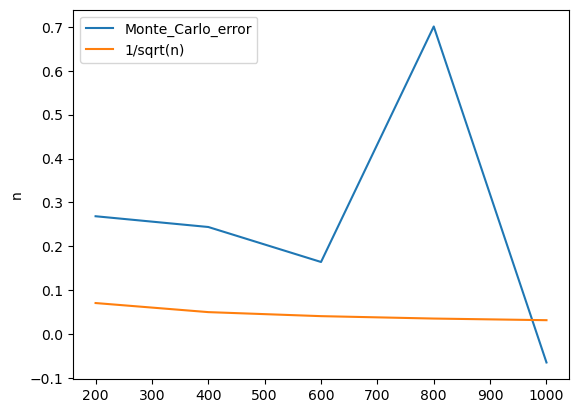

In [127]:
def generate_X(num_points=100, sigma_x=1, sigma_y=1, r_12=0.99, my=0):
    return lognormal_correlated_bivariate_dist(
        transform_to_correlated_by_cholesky(sigma_x, sigma_y, r_12, create_chi_n_c(num_points), my))


y = np.arange(0, 1001, 200)
x = np.fromiter(
    [(A_chi_N_c_Monte_Carlo(lognormal_correlated_bivariate_dist=generate_X(num_points=i)) - exact) for i in y],
    dtype=float)
fig, ax = plt.subplots()
ax.plot(y, x, label='Monte_Carlo_error')
ax.plot(y, 1 / np.sqrt(y), label='1/sqrt(n)')
ax.set_ylabel('n')
ax.legend()
plt.show()